### Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.graphics.tsaplots as tsaplots
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARMA
import itertools
import random

### Get Data

In [2]:
train = pd.read_csv('./data/train.csv')

# Typecasting data
train.date = pd.to_datetime(train.date, format = '%Y-%m-%d')     
train.store = train.store.astype('category')
train.item = train.item.astype('category')

# New Timeseries that is the aggregate of the sales for all products and all items in a month
ts_monthly = pd.Series(data = train.groupby([train.date.dt.year, train.date.dt.month])['sales'].sum().values)

#### Create Train, Validation and Test Subsets

<ol>
    <li>We divide the timeseries into three parts, 60% train subset, 20% validation subset and 20% test subset.
</ol>

In [3]:
train_idx = np.int(0.6*len(ts_monthly))
val_idx = np.int(0.8*len(ts_monthly))

#### Examining Stationarity train subset

In [4]:
#Examining for Stationarity

result = adfuller(ts_monthly[:train_idx], regression = 'ct')  #'ct' because there is a trend in the timeseries
print("ADF test statistic: %0.4f" % result[0])
print("Critical Values for ADF test statistic")
print("Conf. Int.    Value")
for _, (key, value) in enumerate(result[4].items()):
    print("  %3s        %0.4f" % (key, value))
print("\np-value: %0.4e" % result[1])

ADF test statistic: -0.8653
Critical Values for ADF test statistic
Conf. Int.    Value
   1%        -4.3750
   5%        -3.6035
  10%        -3.2382

p-value: 9.5973e-01


#### Observations
The Augmented Dickey-Fuller (ADF) test confirms that the series is not stationary.

We difference the monthly timeseries and check if that helps with making the series stationary.

In [5]:
ser = ts_monthly[:train_idx].diff().dropna()

#Examining for Stationarity

result = adfuller(ser)
print("ADF test statistic: %0.4f" % result[0])
print("Critical Values for ADF test statistic")
print("Conf. Int.    Value")
for _, (key, value) in enumerate(result[4].items()):
    print("  %3s        %0.4f" % (key, value))
print("\np-value: %0.4e" % result[1])

ADF test statistic: -6.8679
Critical Values for ADF test statistic
Conf. Int.    Value
   1%        -3.7377
   5%        -2.9922
  10%        -2.6357

p-value: 1.5426e-09


#### Observartions
The differenced series is indeed stationary.

We now examine if there is autorcorrelation amongst terms of the timeseries  and also examine the differenced series' ACF and PACF plots

In [6]:
# Examining for Autocorrelation amongst terms of timeseries

result = acorr_ljungbox(ts_monthly[:train_idx], lags = 10, return_df = True)
print('The p-value for the Ljung-Box test statistic for the first 10 lags:')
print(result.lb_pvalue.head(10))

The p-value for the Ljung-Box test statistic for the first 10 lags:
1     5.487822e-06
2     1.043596e-06
3     4.036040e-06
4     6.566279e-06
5     2.376441e-07
6     3.913625e-09
7     3.139729e-10
8     5.140199e-10
9     1.458282e-09
10    6.003078e-10
Name: lb_pvalue, dtype: float64


#### Observations
The Ljung-Box test confirms that there indeed exists auto correlation amongst the terms of the monthly time series.

/home/sanjeev/anaconda3/envs/timeseries/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


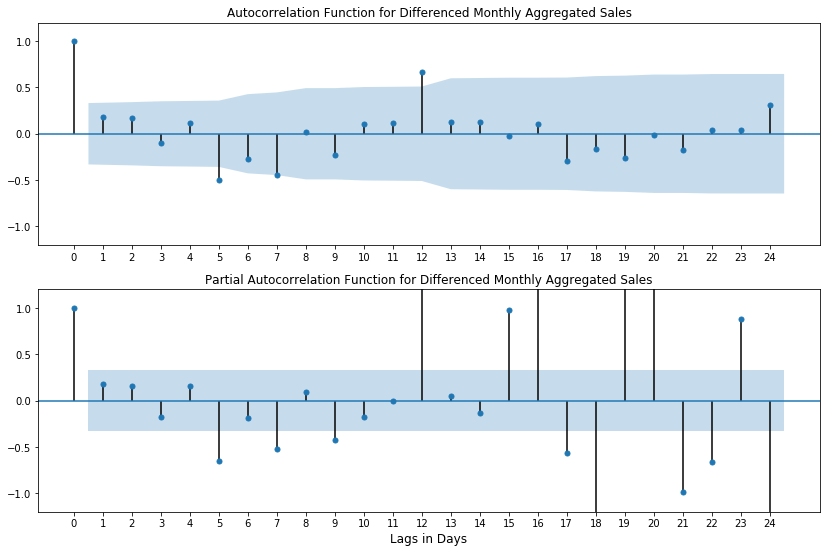

In [7]:
fig, (ax1, ax2) = plt.subplots(nrows = 2, figsize = (14, 9))

tsaplots.plot_acf(ser, ax = ax1, alpha = 0.05, lags = 24,
                  title = 'Autocorrelation Function for Differenced Monthly Aggregated Sales')
tsaplots.plot_pacf(ser, ax = ax2, alpha = 0.05, lags = 24,
                   title = 'Partial Autocorrelation Function for Differenced Monthly Aggregated Sales')

ax1.set_xticks(np.arange(0, 25, 1))
ax1.set_ylim((-1.2, 1.2))
ax2.set_xticks(np.arange(0, 25, 1))
ax2.set_ylim((-1.2, 1.2))
ax2.set_xlabel('Lags in Days', fontsize = '12')

plt.show()

#### Observations
<ol>
    <li>We read the ACF and PACF plots to set up a grid of parameters to test for the SARIMA model.
    <li>From the ACF plot, meaningful peaks at lags 5, suggesting p = 5.
    <li>From the ACF plot, peak at lag 12, but since the underlying series is a monthly series, suggesting P = 0, 1 and s = 12.
    <li>From the PACF plot, meaningful peaks at lags 5, 7, 9 suggesting q = 5, (5, 7), (5, 7, 9).
    <li>From the PACF plot meaningful peaks at lags 12, 15, 16, 17, 18, 19, 20, 21, 22, 23. Taking into account s = 12, this suggests Q = 5, (5, 7), (5, 7, 9)
    <li>The underlying trend in the series suggests d = 0, 1 and D = 0, 1
</ol>

#### Set up Configuration Grid Search

In [8]:
# Configuration options for model()
p = [(0, 0, 0, 0, 1)]
q = [(0, 0, 0, 0, 1), (0, 0, 0, 0, 1, 0, 1), (0, 0, 0, 0, 1, 0, 1, 0, 1)]
d = [0, 1]
P = [0, 1]
Q = [0, (0, 0, 0, 0, 1), (0, 0, 0, 0, 1, 0, 1), (0, 0, 0, 0, 1, 0, 1, 0, 1)]
D = [0, 1]
s = [12]
trend = ['n', 'c', 'ct', 'ctt']

In [9]:
order = itertools.product(p, d, q)
seasonal_order = itertools.product(P, D, Q, s)
configs = itertools.product(order, seasonal_order, trend)
best_smape = 100
history = np.array(ts_monthly[:train_idx])
for config in configs:
    o, s_o, t = config
    try:
        model = SARIMAX(history, order = o, seasonal_order = s_o, trend = t)
        fit = model.fit(disp = False, method = 'powell')
        y_hat = fit.predict(train_idx, val_idx - 1)
        y = ts_monthly[train_idx:val_idx]
        smape = np.mean(abs(y - y_hat)/(abs(y) + abs(y_hat)))*100
        if smape < best_smape:
            best_smape = smape
            best_config = config
    except:
        continue
        
o, s_o, t = best_config
print('The lowest SMAPE score achieved for the validation set = %.4f' % best_smape)
print('The parameters for the model with best SMAPE:')
print('order = %s, seasonal_order = %s, trend = %s' % best_config)


/home/sanjeev/anaconda3/envs/timeseries/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/sanjeev/anaconda3/envs/timeseries/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/sanjeev/anaconda3/envs/timeseries/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:868: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)
/home/sanjeev/anaconda3/envs/timeseries/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:994: UserWarning: Non-stationary starting seasonal autoregressive Usin

/home/sanjeev/anaconda3/envs/timeseries/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/sanjeev/anaconda3/envs/timeseries/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/sanjeev/anaconda3/envs/timeseries/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/sanjeev/anaconda3/envs/timeseries/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/sanjeev/anaconda3/envs/timeseries/lib/python3.7/site-packages/stat

The lowest SMAPE score achieved for the validation set = 0.6485
The parameters for the model with best SMAPE:
order = ((0, 0, 0, 0, 1), 0, (0, 0, 0, 0, 1, 0, 1, 0, 1)), seasonal_order = (0, 1, (0, 0, 0, 0, 1, 0, 1, 0, 1), 12), trend = ctt


#### Observations
<ul>
    <li>We now fit the model for the cross-validated parameter values of the fit configuration parameters and get the predictions for the validation set.
    <li>We plot the actual and predicted values for the validation set to visually understand the quality of the fit.
</ul>

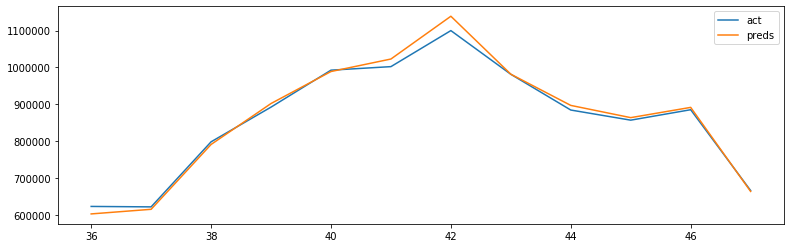

In [10]:
model = SARIMAX(history, order = o, seasonal_order = s_o, trend = t)
fit = model.fit(disp = False, method = 'powell')
y_hat = fit.predict(train_idx, val_idx-1)
y = ts_monthly[train_idx:val_idx]

plt.figure(figsize = (13, 4))
plt.plot(ts_monthly.index[train_idx:val_idx], y_hat, label = 'act')
plt.plot(ts_monthly.index[train_idx:val_idx], y, label = 'preds')
plt.legend()
plt.show()

#### Observations
We have a good set of cross validated parameter values. We use these to build a new model that includes both the train and validation subsets and use the resulting model to estimate the likely test set error using the test subset. 

/home/sanjeev/anaconda3/envs/timeseries/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/sanjeev/anaconda3/envs/timeseries/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:868: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)


The estimated test set SMAPE = 5.1307


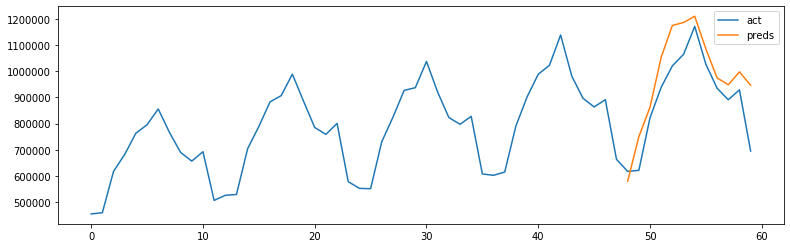

In [11]:
history = np.array(ts_monthly[:val_idx])

model = SARIMAX(history, order = o, seasonal_order = s_o, trend = t)
fit = model.fit(disp = False, method = 'powell')
y_hat = fit.predict(val_idx, len(ts_monthly) - 1)
y = ts_monthly[val_idx:]
smape = np.mean(abs(y - y_hat)/(abs(y) + abs(y_hat)))*100

print("The estimated test set SMAPE = %.4f" % smape)

plt.figure(figsize = (13, 4))
plt.plot(ts_monthly.index, ts_monthly, label = 'act')
plt.plot(ts_monthly.index[val_idx:], y_hat, label = 'preds')
plt.legend()
plt.show()